<a href="https://colab.research.google.com/github/jae-finger/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


#0. Imports, Data, Target CI

In [0]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [0]:
#Data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2019-11-18 01:57:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data.1’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.1s    

2019-11-18 01:57:20 (135 KB/s) - ‘house-votes-84.data.1’ saved [18171/18171]



In [0]:
col_names = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']
df = pd.read_csv('house-votes-84.data', header = None, names= col_names, na_values= '?')

#Quantify yays and nays
df = df.replace({'n':0, 'y':1})
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
#I want to find the 95% confidence interval of average democrat support of mx-missile
missile = df[['party', 'mx-missile']]
missile.head()

,party,mx-missile
0,republican,0.0
1,republican,0.0
2,democrat,0.0
3,democrat,0.0
4,democrat,0.0


#1. Generate and numerically represent a confidence interval

In [0]:
#Set out necessary parameters for CI
from scipy.stats import t
#Sample Size
n = len(missile)

#Degrees of freedom
dof = n-1

#Mean
mean = np.mean(missile)

#Standard deviaion
s_dev = np.std(missile)

#Standard Error
std_error = s_dev/n**.5

#CI
ci = t.interval(.95, dof, loc=mean, scale=std_error)
print("95% confidence interval:", ci)

95% confidence interval: (array([0.45409285]), array([0.54832845]))


#2. Graphically (with a plot) represent the confidence interval

In [0]:
missile1.value_counts()

1.0    207
0.0    206
Name: mx-missile, dtype: int64

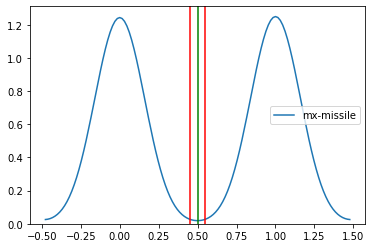

In [0]:
#Graph kde of data
colx = missile['mx-missile']
missile1 = colx[~np.isnan(colx)]
mean = missile1.mean()
sns.kdeplot(missile1);
plt.axvline(ci[1], color='red')
plt.axvline(ci[0], color='red')
plt.axvline(mean, color='green')

#3. Interpret the confidence interval - what does it tell you about the data and its distribution?

The confidence interval tells us with 95% certainty the population mean lies within 45% and 55%.

#4. Take a dataset that we have used in the past in class that has categorical variables. Pick two of those categorical variables and run a chi-squared tests on that data

In [0]:
#Titanic data
url = 'https://raw.githubusercontent.com/austinlasseter/pandas_visualization/master/data/titanic.csv'
dft = pd.read_csv(url)
dft.head()

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0,3,male,22.0,7.2500,Southampton
1,1,1,female,38.0,71.2833,Cherbourg
2,1,3,female,26.0,7.9250,Southampton
3,1,1,female,35.0,53.1000,Southampton
4,0,3,male,35.0,8.0500,Southampton


In [0]:
#Two categorical comparison. Crosstab of people in each class by gender.
pd.crosstab(dft['Pclass'], dft['Sex'])

Sex,female,male
Pclass,,
1,83,101
2,74,99
3,102,253


In [0]:
titanic_chi = pd.crosstab(dft['Pclass'], dft['Sex'])

In [0]:
#import
from scipy.stats import chisquare
#chisquare in scipy
chisquare(titanic_chi, axis=None)

Power_divergenceResult(statistic=187.83146067415726, pvalue=1.1358099173920005e-38)

In [0]:
#by hand in numpy

Sex
female     83
male      101
Name: 1, dtype: int64

In [0]:
titanic_chi['all'] = titanic_chi['female'] + titanic_chi['male']
total = [titanic_chi['male'].sum(), titanic_chi['female'].sum(), titanic_chi['all'].sum()]
total = pd.DataFrame(total).T
total = total.rename(columns={0: 'female', 1: 'male', 2:'all'})
total
titanic_chi = titanic_chi.append(total)
titanic_chi

Sex,female,male,all
1,83,101,184
2,74,99,173
3,102,253,355
0,453,259,712


In [0]:
#Created expected
col_sums= titanic_chi.iloc[3, 0:3]
row_sums= titanic_chi.iloc[0:3, 2]
row_sums

1    184
2    173
3    355
Name: all, dtype: int64

In [0]:
expected = []
total = titanic_chi.iloc[3,2]
total

712

In [0]:
observed = pd.crosstab(dft['Pclass'], dft['Sex']).values
observed

array([[ 83, 101],
       [ 74,  99],
       [102, 253]])

In [0]:
range(len(row_sums))

range(0, 3)

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)